# OpenAI Universe part 3: playing Space Invadors with deep reinforcement learning. 
In part 2 we explored deep q-networks. We implemented a simple network that, if everything went well, was able to solve the Cartpole environment. Atari games are more fun than the CartPole environment, but are also harder to solve. This session is dedicated to playing Atari with deep reinforcement learning. 

A first warning before you are disappointed is that playing Atari games is more difficult than cartpole, and training times are way longer. This is the reason we toyed around with CartPole in the previous session. 

In this session I will show how you can use OpenAI gym to replicate the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). A video of a Breakout playing robot [can be found on Youtube](https://www.youtube.com/watch?v=V1eYniJ0Rnk), as well as a video of a [Enduro playing robot](https://www.youtube.com/watch?v=6kO4eZWeKOM). Demis Hassabis, the CEO of DeepMind, can explain what happend in their experiments in a [very entertaining way](https://youtu.be/rbsqaJwpu6A?t=9m55s). 

A big difference between the CartPole and Atari task is that the Atari environment gives you the raw pixels as observation. Instead of 4 variables you are now dealing with $210 * 160 * 3 = 100.800$ variables as input. The network you build in part 2 is not going to play very well. This means you can either improve your network yourself, or you can replicate the DeepMind layout. This session is only dedicated to showing what the DeepMind network is able to do. 

Flood Sung was able to put the network in Tensorflow and [put the code on GitHub](https://github.com/songrotek/DQN-Atari-Tensorflow). I downloaded his network architecture, updated it to the latest Tensorflow version, changed some parameters and added it to the Git repository of this [summerschool session](https://github.com/rmeertens/reinforcementlearning-tensorflow-tradr-summerschool).

This tutorial has dependencies on Tensorflow, OpenCV, OpenAI Gym, and some other things. Just as with part 1 and 2 the best thing to do is run this code using [Docker](https://docs.docker.com/engine/installation/#supported-platforms). Run the following command to download my prepared docker image and navigate to http://localhost:8888 to view your Jupyter notebook. 
```
docker run -p 8888:8888 -v rmeertens/tensorflowgym
```

 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import random
import cv2
import sys
from BrainDQN_Nature import *
import numpy as np 

import gym


env = gym.make('SpaceInvaders-v0')
env.reset()
actions = env.action_space.n
brain = BrainDQN(actions)

[2017-07-11 13:46:00,813] Making new env: SpaceInvaders-v0


dimension: 3136
dimension: 3136
Successfully loaded: ./savedweights/network-dqn-7580000


### Image preprocessing
As mentioned above we are dealing with $210 * 160 * 3 = 100.800$ variables. The authors of the Playing Atari with DRL solve this by turning the image to grayscale, resizing to 84 x 110, and removing the first 26 rows as they only contain the score. This gives you $84 * 84 = 7.056$ variables per image.

Unfortunately, you need to have a sense of time for some Atari games. For example, what is happening in this image? Is the ball going up? Going down? Left or right? That's why we concatenate the last four "images" of 84x84 to get an 84x84x4 image as input (which is $84*84*4=28.224$ input variables for our neural network. 
![Breakout](https://cbssanfran.files.wordpress.com/2015/02/block-up.jpg)


Before processing: (210, 160, 3)


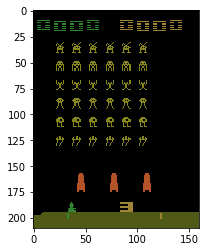

After processing: (84, 84, 1)


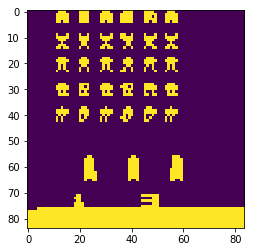

In [2]:
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))


action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(observation0))
plt.show()
observation0 = preprocess(observation0)
print("After processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(np.squeeze(observation0)))
plt.show()

brain.setInitState(observation0)
brain.currentState = np.squeeze(brain.currentState)


### Network layout

Open the file BrainDQN_Nature.py and take a look at the function createQNetwork. You will see that this network consists of: 
- 3 convolational layers
- 2 fully connected layers

The convolutional layers might be new to you. The best way to learn about them is by taking a look at the [Udacity course "Deep Learning"](https://www.udacity.com/course/deep-learning--ud730), or if you quickly want to know what a conv layer is, [watch this video](https://www.youtube.com/watch?v=jajksuQW4mc). 

Also note that this implementation uses a target network (discussed in part 2) that is regularly updated. 

### Learning
Most interesting things happen in the BrainDQN_Nature.py script. We ask the brain for an action, process the new observation, and give this back to the brain. This means we only have to use a few lines to start the learning of the network. 

Note that learning can take a very long time. This script is set to run forever, so start it in the evening and see what the network learned in the morning!

In [3]:

while True:
    action = brain.getAction()
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    
    if terminal:
        nextObservation = env.reset()
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)

TIMESTEP 0 / STATE observe / EPSILON 1.0
TIMESTEP 10000 / STATE observe / EPSILON 1.0


KeyboardInterrupt: 

### Evaluation
After you let your network train for some hours, interrupt the python kernel and run the following script. 
It is important to set the epsilon value of the brain to a low value (0.0 or 0.1), otherwise your brain might keep performing random actions...


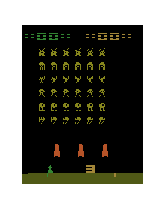
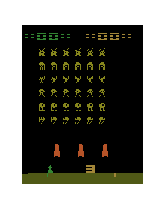
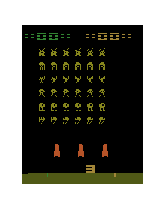
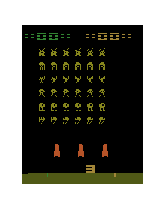
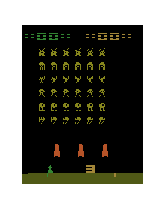
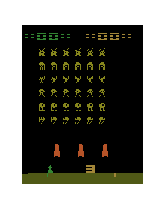
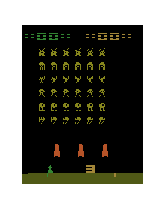
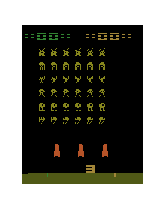
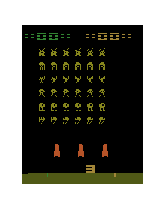
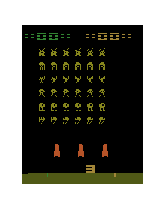
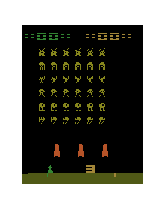
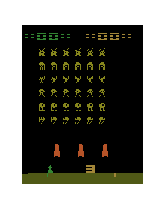
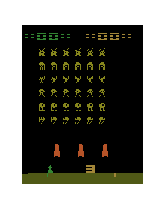
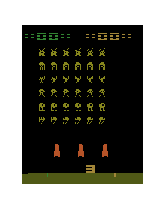
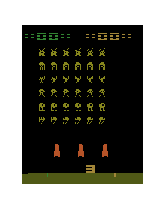
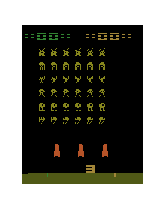
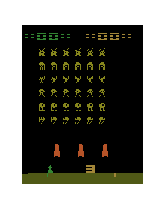
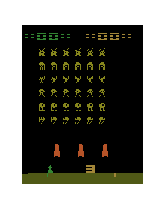
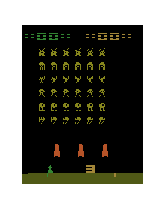
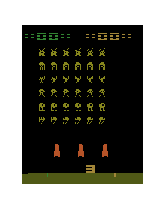
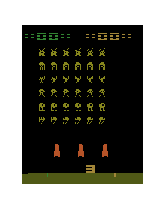
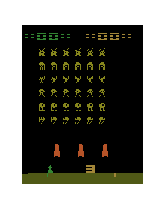
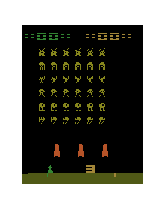
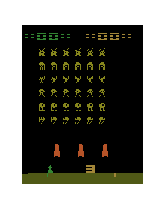
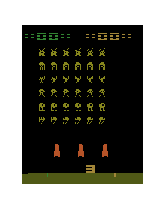
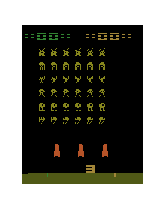
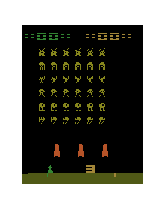
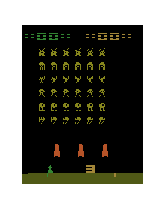
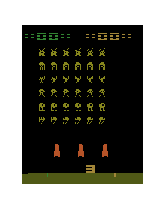
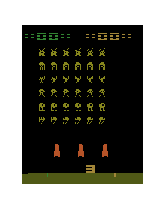
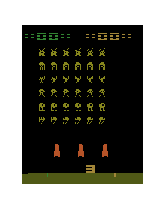
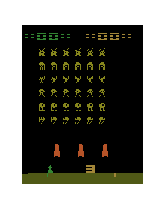
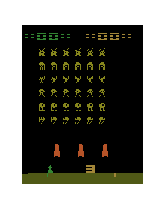
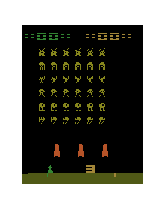
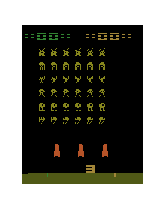
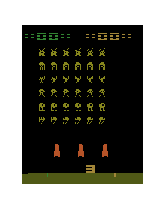
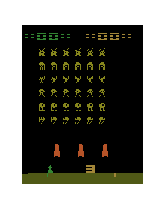
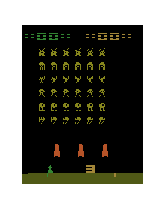
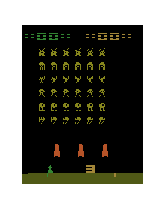
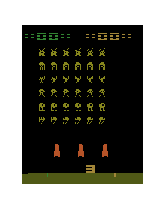
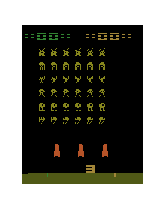
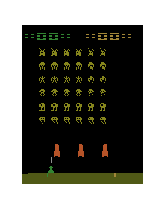
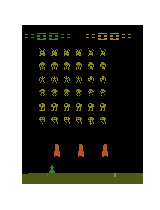
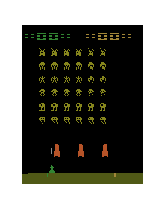
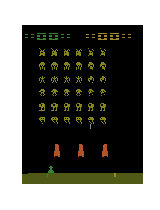
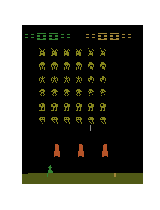
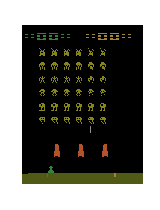
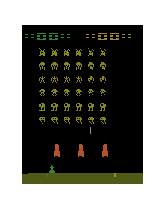
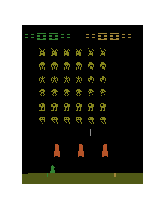
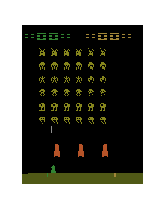
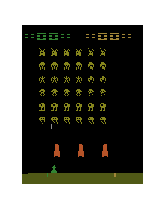
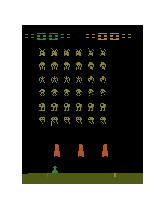
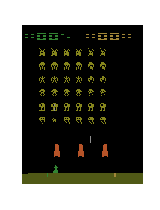
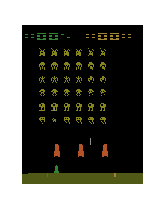
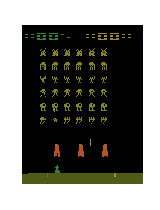
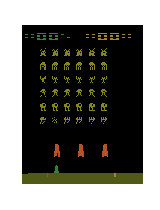
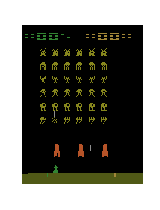
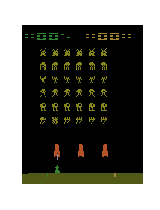
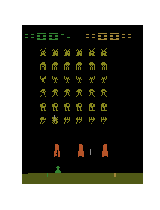
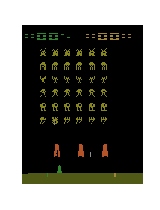
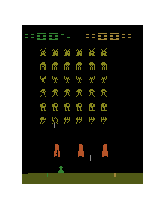
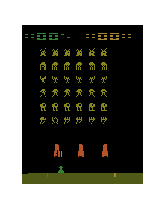
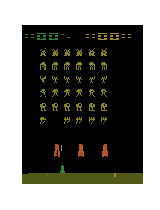
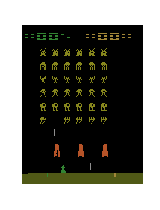
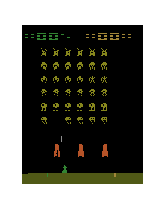
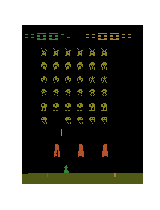
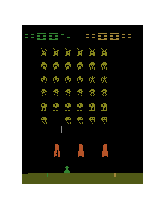
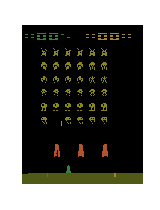
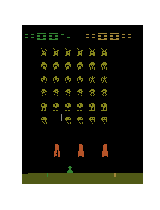
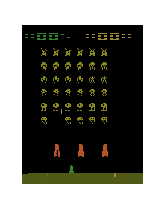
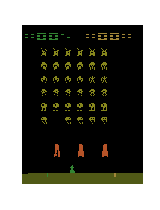
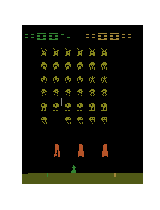
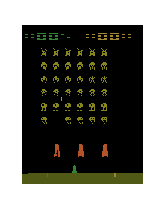
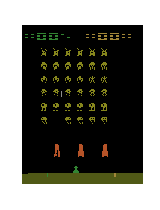
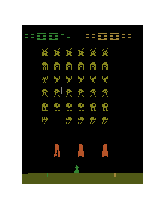
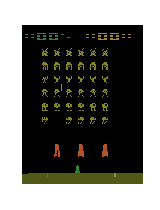
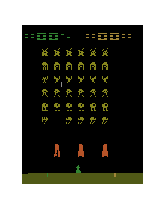
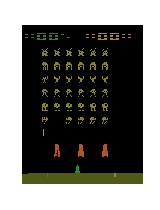
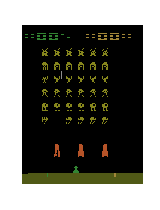
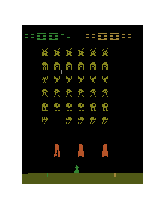
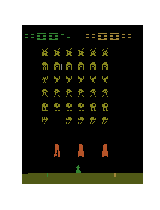
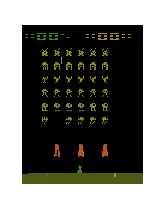
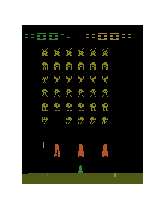
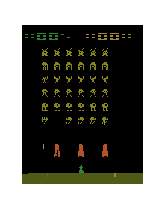
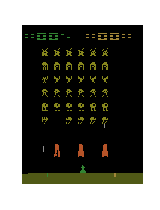
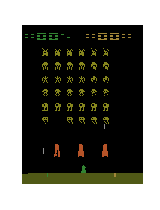
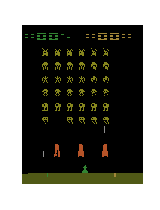
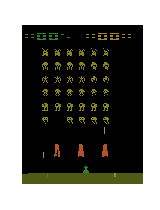
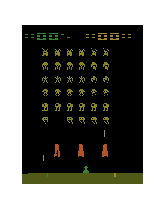
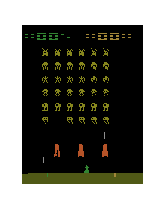
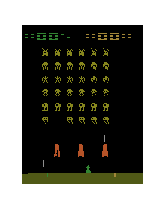
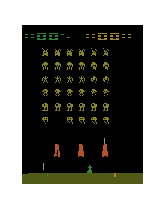
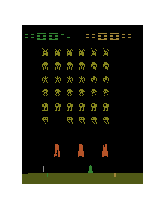
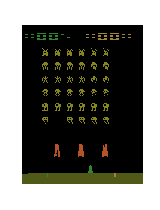
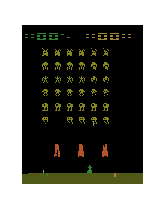
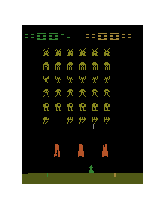
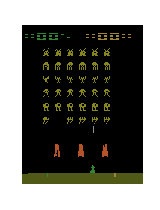
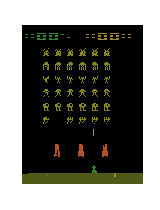
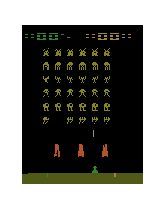
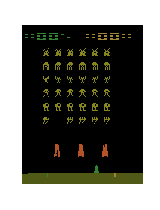
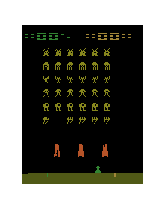
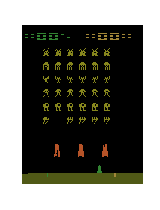
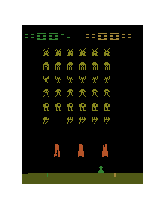
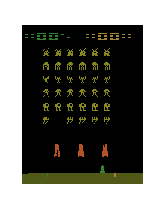
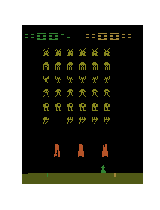
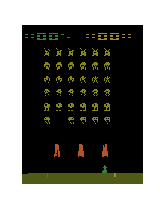
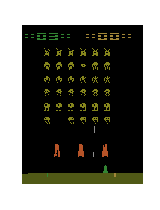
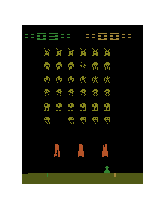
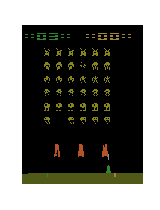
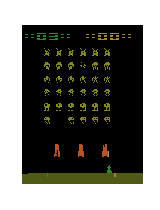
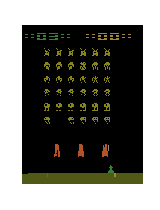
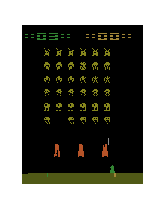
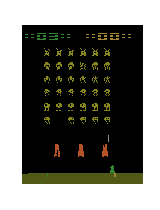
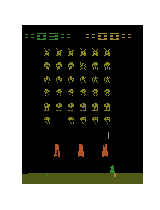
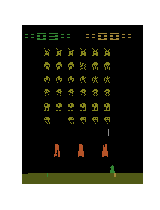
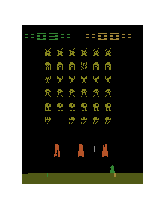
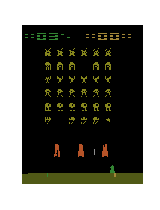
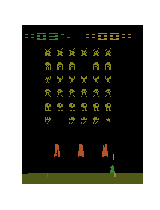
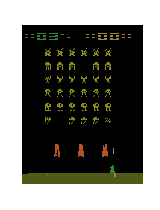
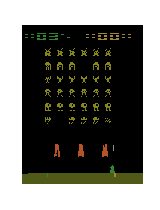
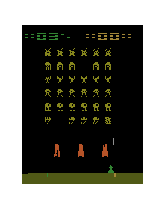
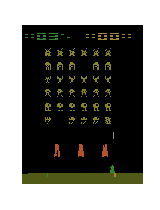
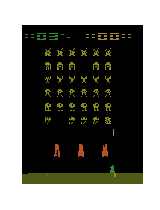
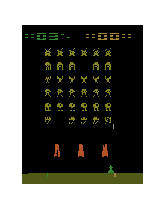
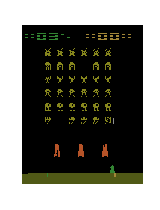
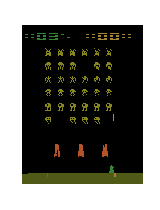
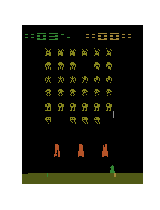
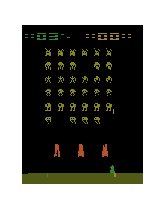
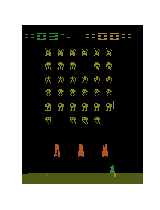
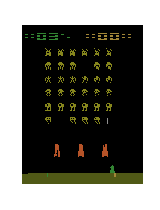
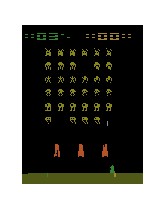
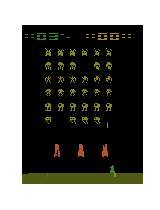
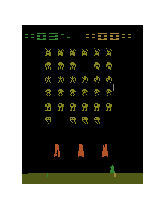
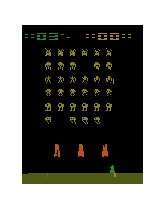
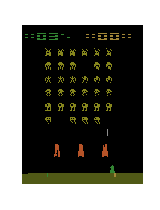
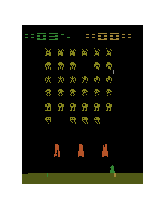
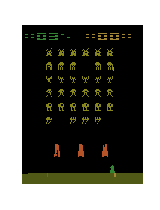
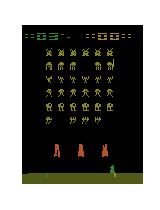
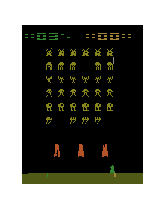
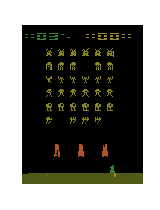
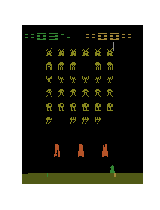
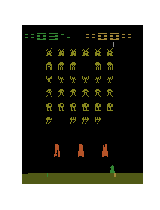
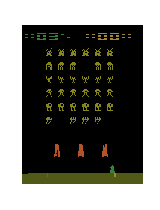
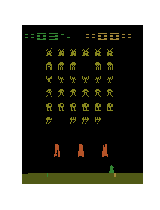
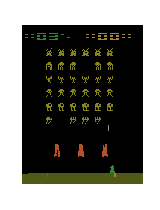
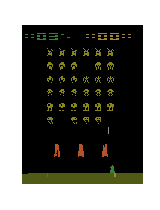
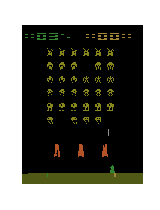
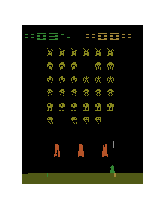
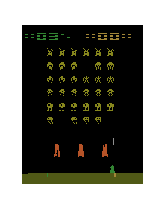
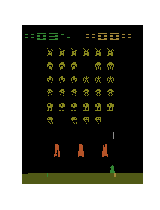

In [8]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

    
frameshistory = []
observation = env.reset()
backupepsilon = brain.epsilon

brain.epsilon = 0.2

for _ in range(150):
    action = brain.getAction()
    
    #print(action)
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    if terminal:
        nextObservation = env.reset()
    frameshistory.append(nextObservation)
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)
brain.epsilon = backupepsilon
    
display_frames_as_gif(frameshistory, 'playing_space_invaders.gif')

![Playing space invaders](http://www.pinchofintelligence.com/wp-content/uploads/2017/07/playing_space_invaders.gif)
## Exercises
This session you were handed the network layout and training methods described in the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). 

### Team up
Humans are very good at learning to play these Atari games. Once I learned aliens kill me with bullets and I got points for killing each alien I was quickly getting many points in the game. Unfortunately our programmed brain is terrible at learning how to play the game (it needs a day, and a lot of frames, before it is able to consistently avoid bullents and kill aliens). Part of the problem is that it is difficult to estimate a reward from observations of random behaviour. The agent would be able to make a better guess of the Q-value if it would be fed with a well-played game of space invaders. The exercises I though would be interesting are:
- Record yourself or a friend playing a game of Space Invaders and save the observations, actions, and rewards in a replay memory (save this memory for later use). Use this game as initial replay memory of the agent. 
- Record a fully trained agent playing a game of space Invaders and save the observations, actions, and rewards in a replay memory (save this memory for later use). Use this game as initial replay memory of a new agent you are going to train. Think of ways to evaluate how well these agents are doing compared to agents initialised on "random" experiences and see what agents are better. 
- During the first episodes the reply memory of the agent is filled with many useless episodes of the agent only moving around, hitting nothing, getting no reward, etc. Perhaps we can increase the speed of learning by selecting episodes we deem "useful" for the agent. You can either do this by designing a "usefulness heuristic" for episodes. For example: the last X frames before getting a reward are something that should be learned really well, as this apparently was a good move. You can also show few-second videos of users and ask them if these frames show "good" behaviour of the agent. If not: why not remove this nasty memory from his memory?

### Transfer knowledge
Humans are very good at transferring knowledge from one domain to another. Unfortunately, our agent is not that good at this. 
- Try training and agent on one game, and try to see how long it takes for this agent to learn to play another domain. If this topic interests you, take a look at how Deepmind improved [their agent](https://deepmind.com/blog/enabling-continual-learning-in-neural-networks/)


### Acknowledgments 
This blogpost is the first part of my TRADR summerschool workshop on using human input in reinforcement learning algorithms. More information can be found [on their homepage](https://sites.google.com/view/tradr/home)
